In [ ]:
#CASO 3: Predicción de la demanda de 5 productos top de una empresa
import pyodbc
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pylab as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

plt.rcParams['figure.figsize' ] = (16, 9)
plt.style.use('fast')


In [2]:
sql_server="""
DRIVER={ODBC Driver 17 for SQL Server};
Server=US3RN4M3;
database=demo_prediccion;
Trusted_connection=yes;
"""

In [ ]:
query = """


"""


query_suc = """

"""


# query = """
# SELECT
# [F]. [Fecha] AS fecha,
# SUM([H]. [cantidad]) AS cantidad
# FROM
# [demo_prediccion]. [dbo]. [hechos] AS [H]
# INNER JOIN [demo_prediccion]. [dbo]. [Dim_fechas] AS [f] ON [H].[id_DimFechas] = [F].[id]
# GROUP BY [F].[Fecha]
# """

In [4]:
#Configuración para el entrenamiento (hace referencia a dias)
PASOS = 12

In [5]:
#Opcion 1: Permitir que pueda ser modificada la sentencia, y mantenrr el try para evitar de que
# el programa se rompa

def get_sqlconnection(config_sqlServer):
    status = "inicializando...."
    try: 
        connection = pyodbc.connect(sql_server)
        status = "Conexion establecida satisfactoriamente"
    except Exception as e:
        status = "Error al establecer la conexión:"+e
    print(status)
    return connection

#Original:
# def get_sqlconnection(config_sqlServer):
#     connection = pyodbc.connect(config_sqlServer)
#     print("Se ha conectado a la base de datos")
#     return connection


In [6]:
def set_index_datetime(data):
    if str(type(data) == "<class 'pandas.core.frame.DataFrame'>"):
        # data.sort_values('fecha', inplace=True)
        for column in data.columns: 
            try: 
                pd.to_datetime(data[column])
                data.set_index(column,inplace=True)
                return data
            except Exception as e:  
                pass
    else: 
        return 0
    
# def set_index_datetime(data):
#     if isinstance(data, pd.DataFrame):
#         for column in data.columns:
#             try:
#                 if column == 'fecha':
#                     data[column] = pd.to_datetime(data[column])
#                     data.set_index(column, inplace=True)

#                 data = data.groupby('fecha').sum().reset_index()
#                 data.dropna(inplace=True)
#                 return data
#                 # data[column] = pd.to_datetime(data[column])
#                 # data.set_index(column, inplace=True)
#                 # return data
#             except Exception as e:
#                 print(f"Error al convertir la columna {column} a datetime: {e}")
#                 pass
#     else:
#         return 0

In [7]:
# with get_sqlconnection(sql_server) as cursor:
#     data = pd.read_sql_query(query,cursor)
#     print(data)
#     data.plot()

#     data = set_index_datetime(data)
#     print(data)

#     data.plot()

In [8]:
def series_to_supervised(data, n_in=1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var&d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
def create_x_y_train(data):
    values = data.values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values= values.reshape(-1, 1)
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    values = reframed.values
    n_train_days = int(len(data)) - (30+PASOS)
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]
    x_train, y_train = train[:, :- 1], train[:, -1]
    x_val, y_val = test[:, :- 1], test[:, -1]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
    return x_train, y_train, x_val, y_val, scaler, values

In [10]:
def crear_modeloFF():
    model = Sequential()
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error', optimizer='Adam',metrics=['mse' ])
    model.summary()
    return model

In [11]:
def entrenar_modelo(x_train, y_train, x_val, y_val, scaler, values, data, model) :
    EPOCHS = 100
    model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val), batch_size=PASOS)
    model.predict(x_val)
    ultimosDias = data[data.index[int(len(data)*0.70)]:]
    values = ultimosDias.values
    values = values.astype('float32' )
    values = values.reshape(-1, 1)
    scaled = values
    reframed = series_to_supervised(scaled, PASOS, 1)
    reframed.drop(reframed.columns[[12]], axis=1, inplace=True)
    values = ultimosDias.values
    values = values.astype('float32' )
    values = values.reshape(-1, 1)
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    reframed.drop(reframed.columns[[12]], axis=1, inplace=True)
    values = reframed.values
    x_test = values[len(values)-1:, :]
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]) )
    return model, x_test

In [12]:
def agregarNuevoValor(x_test, nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test. shape[2]-1] = nuevoValor
    return x_test

In [13]:
def eliminar_anomalias(dtaframe):
    dataFrame_anomalias = dtaframe.copy()
    modeloIsolation = IsolationForest(contamination=0.05)
    modeloIsolation.fit(dataFrame_anomalias)
    anomalias = modeloIsolation.predict(dataFrame_anomalias)
    dtaframe['anomalias' ] = anomalias
    dataFrameSinAnomalias = dtaframe[dtaframe['anomalias' ] != -1]
    dataFrameSinAnomalias = dataFrameSinAnomalias.drop('anomalias', axis=1)
    return dataFrameSinAnomalias

In [14]:

#El Core del sistema
with get_sqlconnection(sql_server) as cursor:
    datos = pd.read_sql_query(query, cursor)
    datos = set_index_datetime(datos)
    # datos.plot()

    #Predicción de acuerdo a la oultima fecha registrada que fue en el 2020-12-31
    last_day = datetime.strptime(datos.index.max(), '%Y-%m' ) + relativedelta(months=1)
    # print(last_day)

    #Predicción que se hará de acierdo a los pasos que se han definido 
    future_days = [last_day + relativedelta(months=i) for i in range(PASOS)]
    # future_days = [last_day + relativedelta(days=i) for i in range(1, PASOS+1)]
    # print(future_days)

    #Reesctructuramos los datos que se han obtenido, tomando solo los ultimos 10 digitos
    #future_days = [str(i)[:10] for i in future_days]
    for i in range(len(future_days)):
        future_days[i] = str(future_days[i])[:10]
    print(future_days)

    #Cremos un arreglo para poder tomar todas las fechas
    #Que servirá para predecir fechas futuras
    future_data = pd.DataFrame(future_days)
    future_data.columns = ['fecha']

Conexion establecida satisfactoriamente


C:\Users\JoCel\AppData\Local\Temp\ipykernel_11412\1419587430.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  datos = pd.read_sql_query(query, cursor)


['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01']


In [15]:
    

    #Creamos un modelo de datos
    model = crear_modeloFF()
    for column in datos.columns:
        data = datos.filter([column])
        data.set_index(datos.index, inplace=True)
        data = eliminar_anomalias(data)
        x_train, y_train, x_val, y_val, scaler, values = create_x_y_train(data)
        model, x_test = entrenar_modelo(x_train, y_train, x_val, y_val, scaler, values, data, model)
        results = []
        for i in range(PASOS):
            parcial = model.predict(x_test)
            results.append(parcial[0])
            x_test = agregarNuevoValor(x_test, parcial[0])
        adimen = [x for x in results]
        inverted = scaler.inverse_transform(adimen)
        y_pred = pd.DataFrame(inverted.astype(int))
        future_data[column]= inverted.astype(int)
    future_data = set_index_datetime(future_data)
    print(future_data)



c:\Residencia_proyecto\PRONOSTICO\PRONOSTICO_DE_INVENTARIOS\4.- Recursos\prediccion\envprediccion\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1, 12)          │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169 (676.00 B)

 Trainable params: 169 (676.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.3620 - mse: 0.1919 - val_loss: 0.6366 - val_mse: 0.5610
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3784 - mse: 0.2069 - val_loss: 0.6274 - val_mse: 0.5478
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3659 - mse: 0.1867 - val_loss: 0.6157 - val_mse: 0.5322
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3659 - mse: 0.1881 - val_loss: 0.6058 - val_mse: 0.5198
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3553 - mse: 0.1870 - val_loss: 0.5949 - val_mse: 0.5065
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3501 - mse: 0.1739 - val_loss: 0.5837 - val_mse: 0.4930
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3135 - mse: 0.1452 - val_loss: 0.5711 - val_mse: 0.4785
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3380 - mse: 0.1621 - val_loss: 0.5613 - val_mse: 0.4664
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3282 - mse: 

C:\Users\JoCel\AppData\Local\Temp\ipykernel_11412\2297903707.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_test[0][0][x_test. shape[2]-1] = nuevoValor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2306 - mse: 0.0854 - val_loss: 0.3521 - val_mse: 0.1729
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2145 - mse: 0.0715 - val_loss: 0.3509 - val_mse: 0.1725
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2151 - mse: 0.0705 - val_loss: 0.3507 - val_mse: 0.1733
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2042 - mse: 0.0666 - val_loss: 0.3511 - val_mse: 0.1750
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2076 - mse: 0.0682 - val_loss: 0.3520 - val_mse: 0.1776
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1874 - mse: 0.0553 - val_loss: 0.3540 - val_mse: 0.1818
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

C:\Users\JoCel\AppData\Local\Temp\ipykernel_11412\2297903707.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_test[0][0][x_test. shape[2]-1] = nuevoValor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1694 - mse: 0.0481 - val_loss: 0.2701 - val_mse: 0.1195
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1718 - mse: 0.0458 - val_loss: 0.2714 - val_mse: 0.1203
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1588 - mse: 0.0415 - val_loss: 0.2700 - val_mse: 0.1193
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1732 - mse: 0.0501 - val_loss: 0.2682 - val_mse: 0.1180
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1528 - mse: 0.0387 - val_loss: 0.2681 - val_mse: 0.1179
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1646 - mse: 0.0460 - val_loss: 0.2706 - val_mse: 0.1197
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

C:\Users\JoCel\AppData\Local\Temp\ipykernel_11412\2297903707.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_test[0][0][x_test. shape[2]-1] = nuevoValor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3076 - mse: 0.1518 - val_loss: 0.5616 - val_mse: 0.5201
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2950 - mse: 0.1344 - val_loss: 0.5614 - val_mse: 0.5186
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2890 - mse: 0.1362 - val_loss: 0.5599 - val_mse: 0.5155
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3280 - mse: 0.1700 - val_loss: 0.5561 - val_mse: 0.5111
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2894 - mse: 0.1455 - val_loss: 0.5506 - val_mse: 0.5058
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2847 - mse: 0.1309 - val_loss: 0.5452 - val_mse: 0.5002


C:\Users\JoCel\AppData\Local\Temp\ipykernel_11412\2297903707.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_test[0][0][x_test. shape[2]-1] = nuevoValor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2197 - mse: 0.0708 - val_loss: 0.5423 - val_mse: 0.5631
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2039 - mse: 0.0638 - val_loss: 0.5421 - val_mse: 0.5640
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1995 - mse: 0.0625 - val_loss: 0.5418 - val_mse: 0.5651
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2024 - mse: 0.0623 - val_loss: 0.5414 - val_mse: 0.5665
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2135 - mse: 0.0666 - val_loss: 0.5412 - val_mse: 0.5679
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1883 - mse: 0.0543 - val_loss: 0.5412 - val_mse: 0.5689
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

C:\Users\JoCel\AppData\Local\Temp\ipykernel_11412\2297903707.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_test[0][0][x_test. shape[2]-1] = nuevoValor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
            producto 635  producto 350  producto 176  producto 303  \
fecha                                                                
2021-01-01        235479         47304         33010         11046   
2021-02-01        248901         50583         32357         10861   
2021-03-01        207836         45345         33889         12034   
2021-04-01        244265         43610         33633         10354   
2021-05-01        211703         40988         30170         10229   
2021-06-01        206378         39661         27310          8496   
2021-07-01        213704         41530         32738          7890   
2021-08-01        198158         40759         35292          9424

In [16]:
print(future_data)
print(datos)
# future_data.plot()

            producto 635  producto 350  producto 176  producto 303  \
fecha                                                                
2021-01-01        235479         47304         33010         11046   
2021-02-01        248901         50583         32357         10861   
2021-03-01        207836         45345         33889         12034   
2021-04-01        244265         43610         33633         10354   
2021-05-01        211703         40988         30170         10229   
2021-06-01        206378         39661         27310          8496   
2021-07-01        213704         41530         32738          7890   
2021-08-01        198158         40759         35292          9424   
2021-09-01        229401         44209         37090          9596   
2021-10-01        212583         43879         37316         10643   
2021-11-01        221401         42383         36512          9677   
2021-12-01        244147         46626         37225         10020   

            product

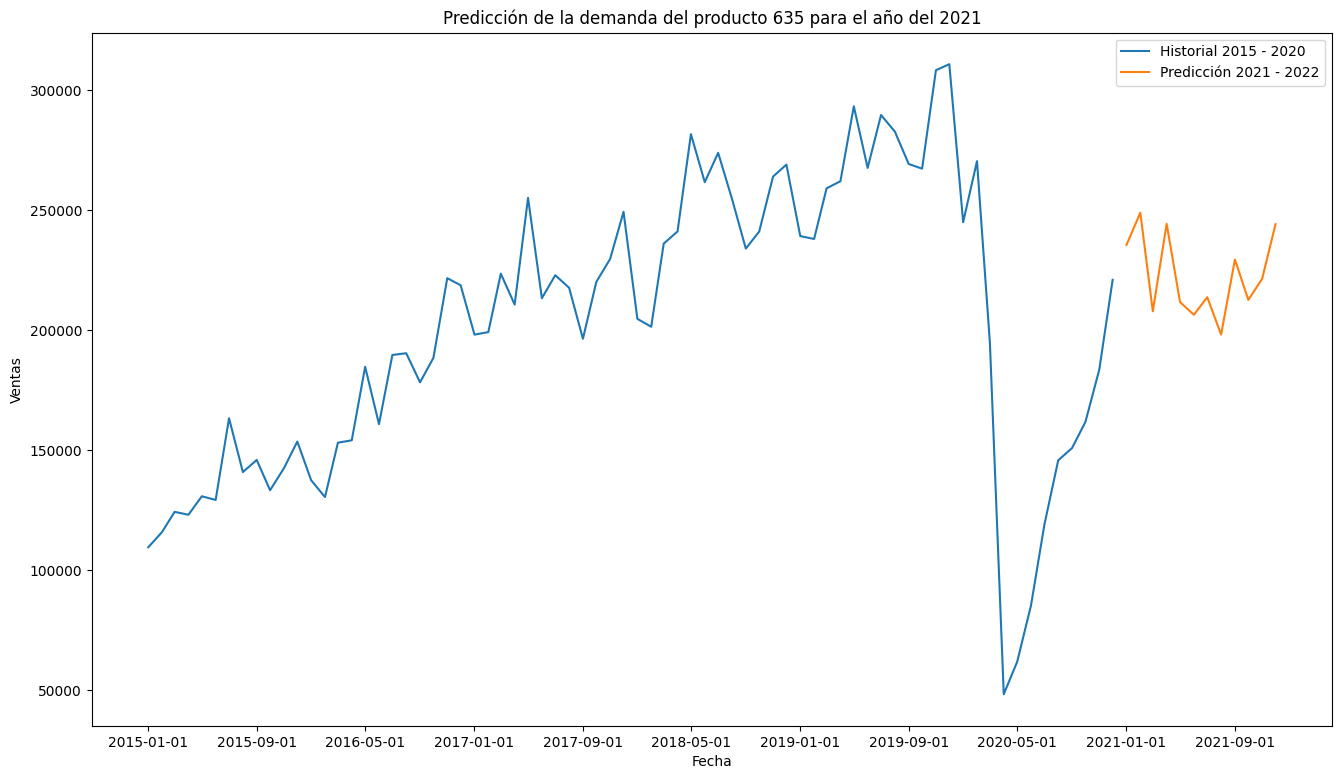

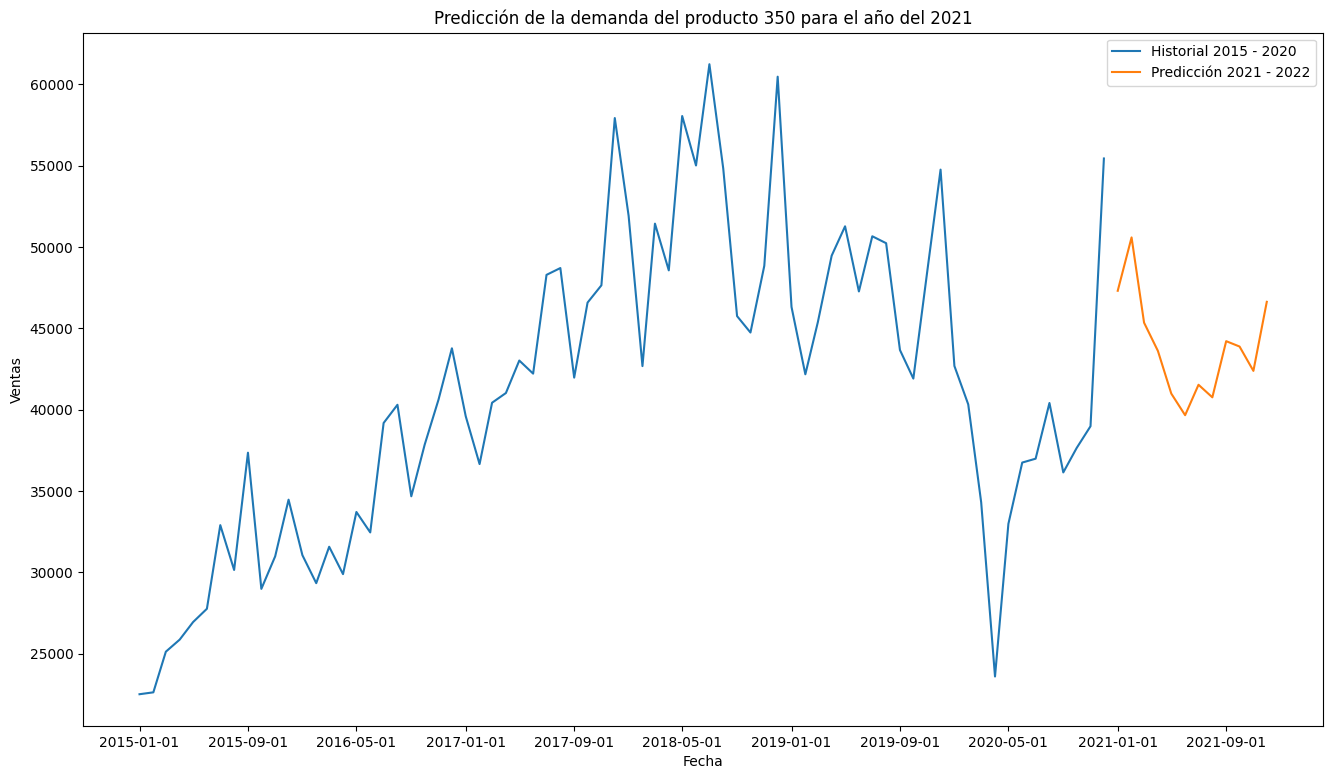

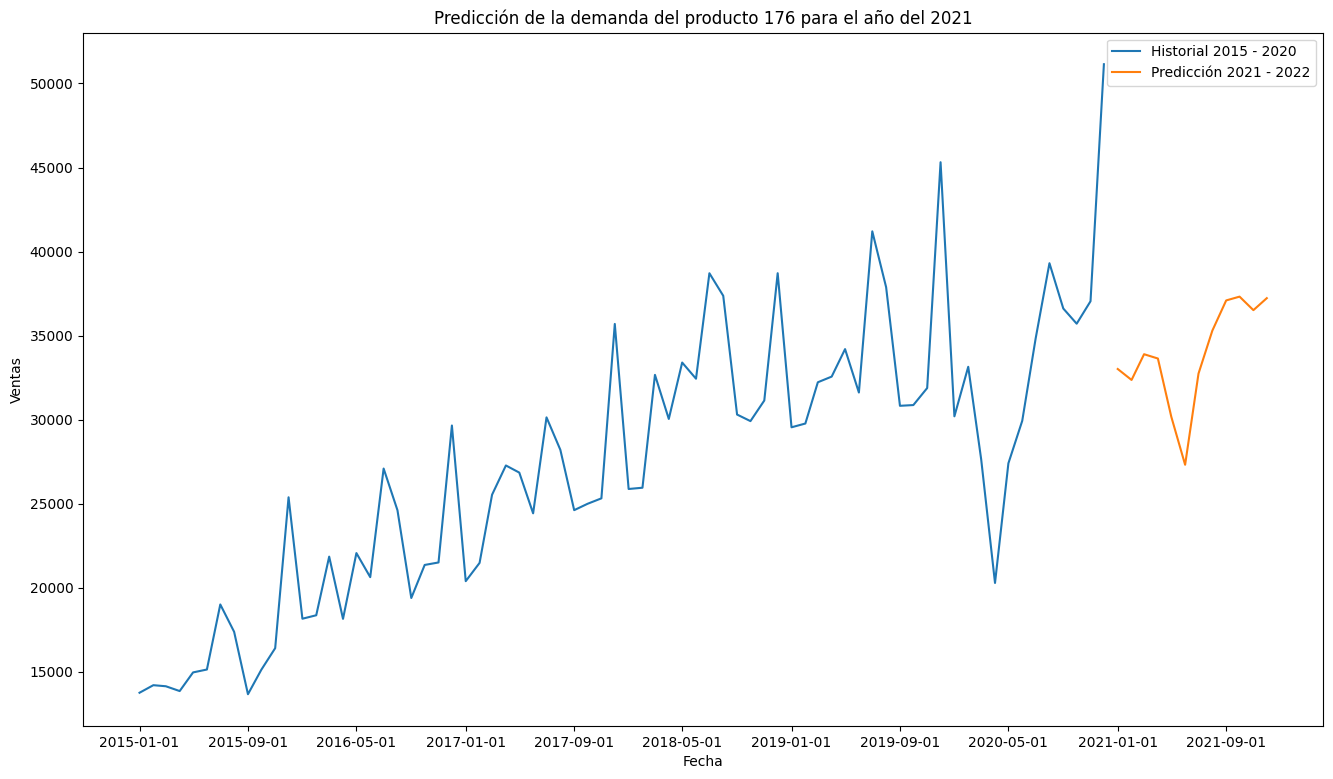

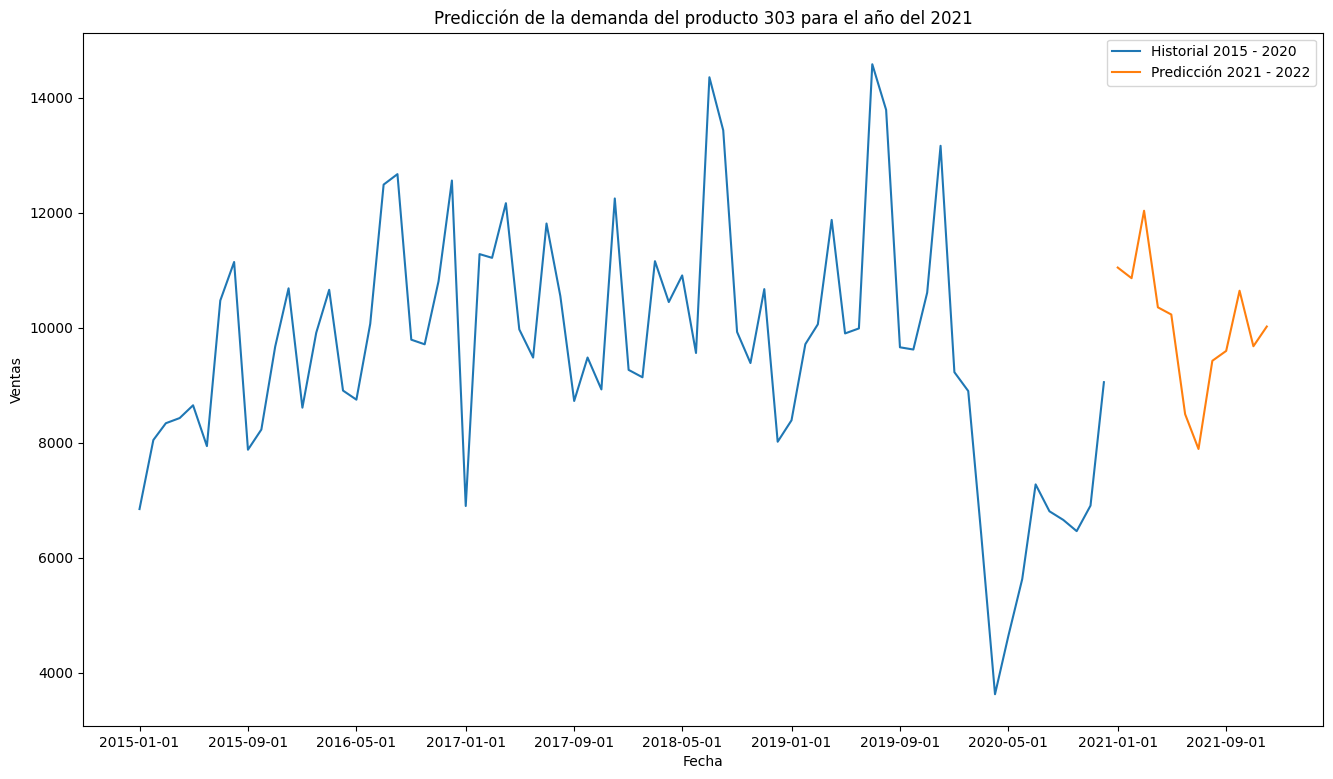

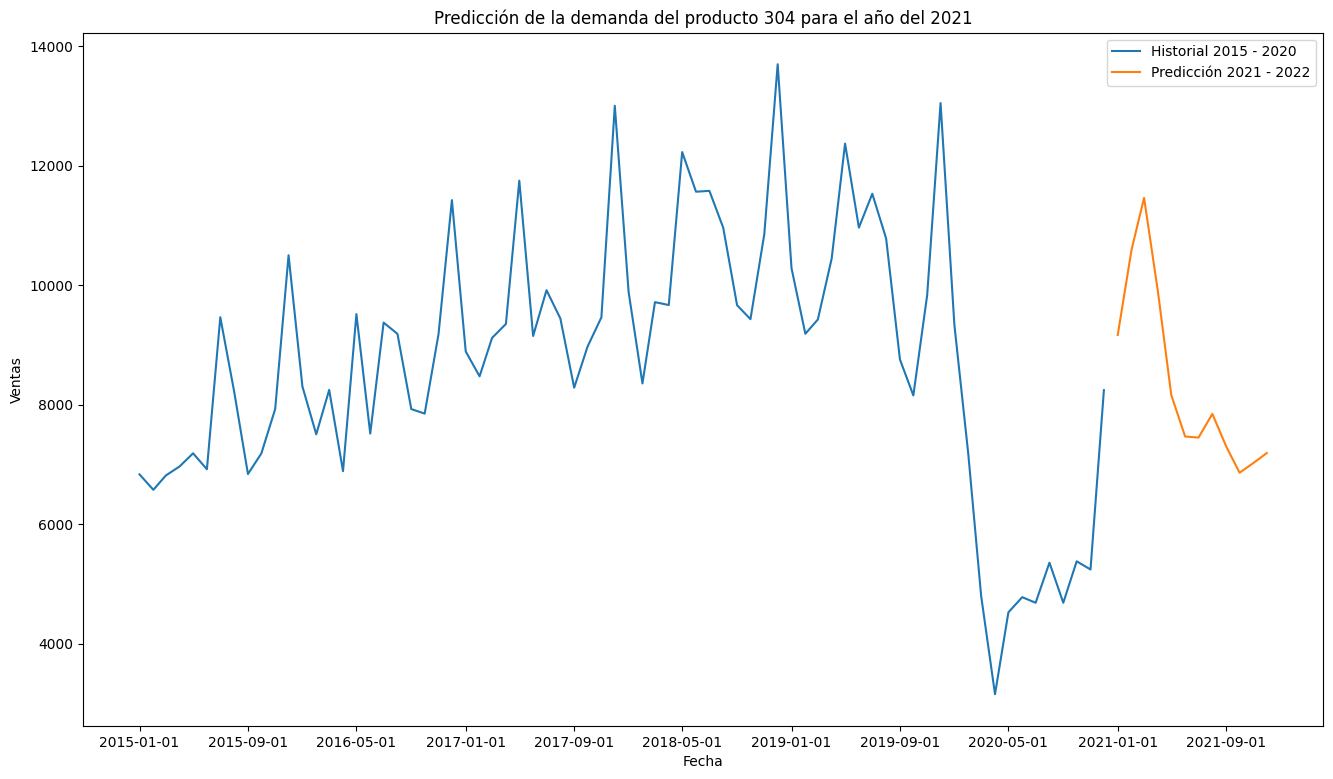

,producto 635,producto 350,producto 176,producto 303,producto 304
fecha,,,,,
2021-01-01,235479,47304,33010,11046,9166
2021-02-01,248901,50583,32357,10861,10594
2021-03-01,207836,45345,33889,12034,11460
2021-04-01,244265,43610,33633,10354,9896
2021-05-01,211703,40988,30170,10229,8160
2021-06-01,206378,39661,27310,8496,7467
2021-07-01,213704,41530,32738,7890,7449
2021-08-01,198158,40759,35292,9424,7846
2021-09-01,229401,44209,37090,9596,7302


In [18]:
    datos.index = pd.to_datetime(datos.index)
    future_data.index = pd.to_datetime(future_data.index)

    #Graficar los dataframes
    for i in range(len(datos.columns)):
        data = datos[datos.columns[i]][:]
        plt.plot(data.index, data,label='Historial 2015 - 2020')
        plt.plot(future_data.index, future_data[future_data.columns[i]], label='Predicción 2021 - 2022')
        xtics = data.index.union(future_data.index)[::8]

        plt.xticks(xtics)
        plt.xlabel('Fecha')
        plt.ylabel('Ventas')
        plt.title('Predicción de la demanda del {p0} para el año del 2021'.format(p0=datos.columns[i]))


        plt.legend()
        plt.show()
    future_data